In [171]:
import os

import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

if os.path.exists(".analysis/layer1.csv"):
    layer1 = pd.read_csv(".analysis/layer1.csv", dtype={"code": str})
    layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
    layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))
else:
    begin = YearMonth(2014, 4)
    end = YearMonth(2023, 10)

    # 월 차트 로드
    print("Fetching month chart...")
    month_chart = pd.read_sql(
        f"""
        select month_chart.*, stocks.stock_name as name from month_chart
        join stocks on month_chart.code = stocks.stock_code
        where year(date) >= {begin.year}
        """,
        maria_home()
    )

    # 재무제표 로드
    print("Loading financial data...")
    fs_loader = FsLoader()

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    yms = list(begin.to(end))
    yms = pd.Series(yms)
    yms = yms.drop_duplicates().sort_values()

    print("Making layer1...")
    for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지
        df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상(거래량 적을 시 매수 실패할거라고 가정)

        df2["close"] = df2["close"].astype(float)
        df2.loc[(df2["open"] == 0) | (df2["val_last"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

        df = pd.DataFrame({
            "매수년월": ym1,
            "매도년월": ym2,
            "종목명": df1["name"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "시가총액": df1["cap"],
            "거래량": df1["vol"],
            "거래대금": df1["val"],
            "전월수익률": df1["close"] / df1["open"] - 1,
            "val": df1["val"],
            "val_last": df1["val_last"],
            "매도가": df2["close"],
            "매도일": df2["date"]
        }).reindex(df1.index)

        shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
        df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
        df.loc[df["매도가"].isna(), "매도가"] = 0
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        settled_qtr = YearQtr.settled_of(ym1.last_date)
        fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1.reset_index(inplace=True)
    layer1.to_csv(".analysis/layer1.csv", index=False)

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1

,code,매수년월,매도년월,종목명,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,EBT/A_QoQ,EBT/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,053330,2014-04,2014-05,영진코퍼레이션,2014-04-30,880.0,1.862769e+10,15777003.0,1.680384e+10,0.045131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,003640,2014-04,2014-05,유니온스틸,2014-04-30,14100.0,1.446660e+11,129768.0,1.908398e+09,-0.056856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,068870,2014-04,2014-05,LG생명과학,2014-04-30,35750.0,5.926274e+11,2745885.0,1.013983e+11,-0.064136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,086830,2014-04,2014-05,신양오라컴디스플레이,2014-04-30,3295.0,2.313090e+10,1654819.0,5.322223e+09,0.069805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200913,042670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,0.029118,-0.050384,0.017786,0.020540,0.015882,0.033000,0.015612,0.033128,0.011726,0.025061
200914,054620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,0.004770,0.005569,-0.002981,-0.006491,-0.005834,-0.008222,-0.007104,-0.015276,-0.006268,-0.012965
200915,238500,2023-09,2023-10,로보쓰리에이아이앤로보틱스,2023-09-27,936.0,2.013819e+10,5678047.0,4.715497e+09,0.485714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200916,424980,2023-09,2023-10,마이크로투나노,2023-09-27,16300.0,9.647791e+10,1606473.0,3.070538e+10,-0.128342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P"
    }
)

factors = [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
factors += ["P"]

# 가격비율
layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
factors.append("EQ/P")

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    factor = f"{col}/P"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["P"]
    factors.append(factor)

    # 자산비율
    factor = f"{col}/A"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["A"]
    factors.append(factor)

    # 자본비율
    factor = f"{col}/EQ"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["EQ"]
    factors.append(factor)

    # 이익율
    factor = f"{col}/R"
    layer2[factor] = layer2[f"{col}/Y"] / layer2["R/Y"]
    factors.append(factor)

recipes = {
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "퀄리티": {
        "GP/EQ": 0.081688,
        "GP/A": 0.068516,
        "O/A": 0.059149,
        "O/R": 0.056152,
        "O/EQ": 0.054418,
        "R/EQ": 0.053285,
        "EBT/A": 0.042171,
        "EBT/R": 0.035214,
        "GP/R": 0.034800,
        "EBT/EQ": 0.034718
    },
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
        "퀄리티": 1,
    }
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    for title, recipe in recipes.items():
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    result = pd.concat([result, df])

result

2023-10

,code,매수년월,매도년월,종목명,매수일,매수가,P,거래량,거래대금,전월수익률,...,E/EQ_pct,E/R_pct,벨류,벨류_pct,퀄리티,퀄리티_pct,성장,성장_pct,전략,전략_pct
0,053330,2014-04,2014-05,영진코퍼레이션,2014-04-30,880.0,1.862769e+10,15777003.0,1.680384e+10,0.045131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,003640,2014-04,2014-05,유니온스틸,2014-04-30,14100.0,1.446660e+11,129768.0,1.908398e+09,-0.056856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,068870,2014-04,2014-05,LG생명과학,2014-04-30,35750.0,5.926274e+11,2745885.0,1.013983e+11,-0.064136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,086830,2014-04,2014-05,신양오라컴디스플레이,2014-04-30,3295.0,2.313090e+10,1654819.0,5.322223e+09,0.069805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200913,042670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,92.0,71.0,129.0,67.0,42.901217,95.0,89.913985,90.0,159.0,82.0
200914,054620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,40.0,78.0,97.0,49.0,12.174374,14.0,46.988587,42.0,57.0,26.0
200915,238500,2023-09,2023-10,로보쓰리에이아이앤로보틱스,2023-09-27,936.0,2.013819e+10,5678047.0,4.715497e+09,0.485714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200916,424980,2023-09,2023-10,마이크로투나노,2023-09-27,16300.0,9.647791e+10,1606473.0,3.070538e+10,-0.128342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[4/4] 전략티2014-04 2023-10


,spearman,kendall,h10,t10,h10-t10,mean,median,strength
전략,0.861434,0.682020,0.239841,-0.122322,0.362163,0.046758,0.044366,0.311980
벨류,0.724356,0.534949,0.121450,-0.085148,0.206598,0.042893,0.043281,0.149650
성장,0.752943,0.566061,0.139561,-0.015359,0.154920,0.046518,0.055300,0.116646
퀄리티,0.247261,0.157980,0.038890,-0.032961,0.071851,0.045480,0.047198,0.017766


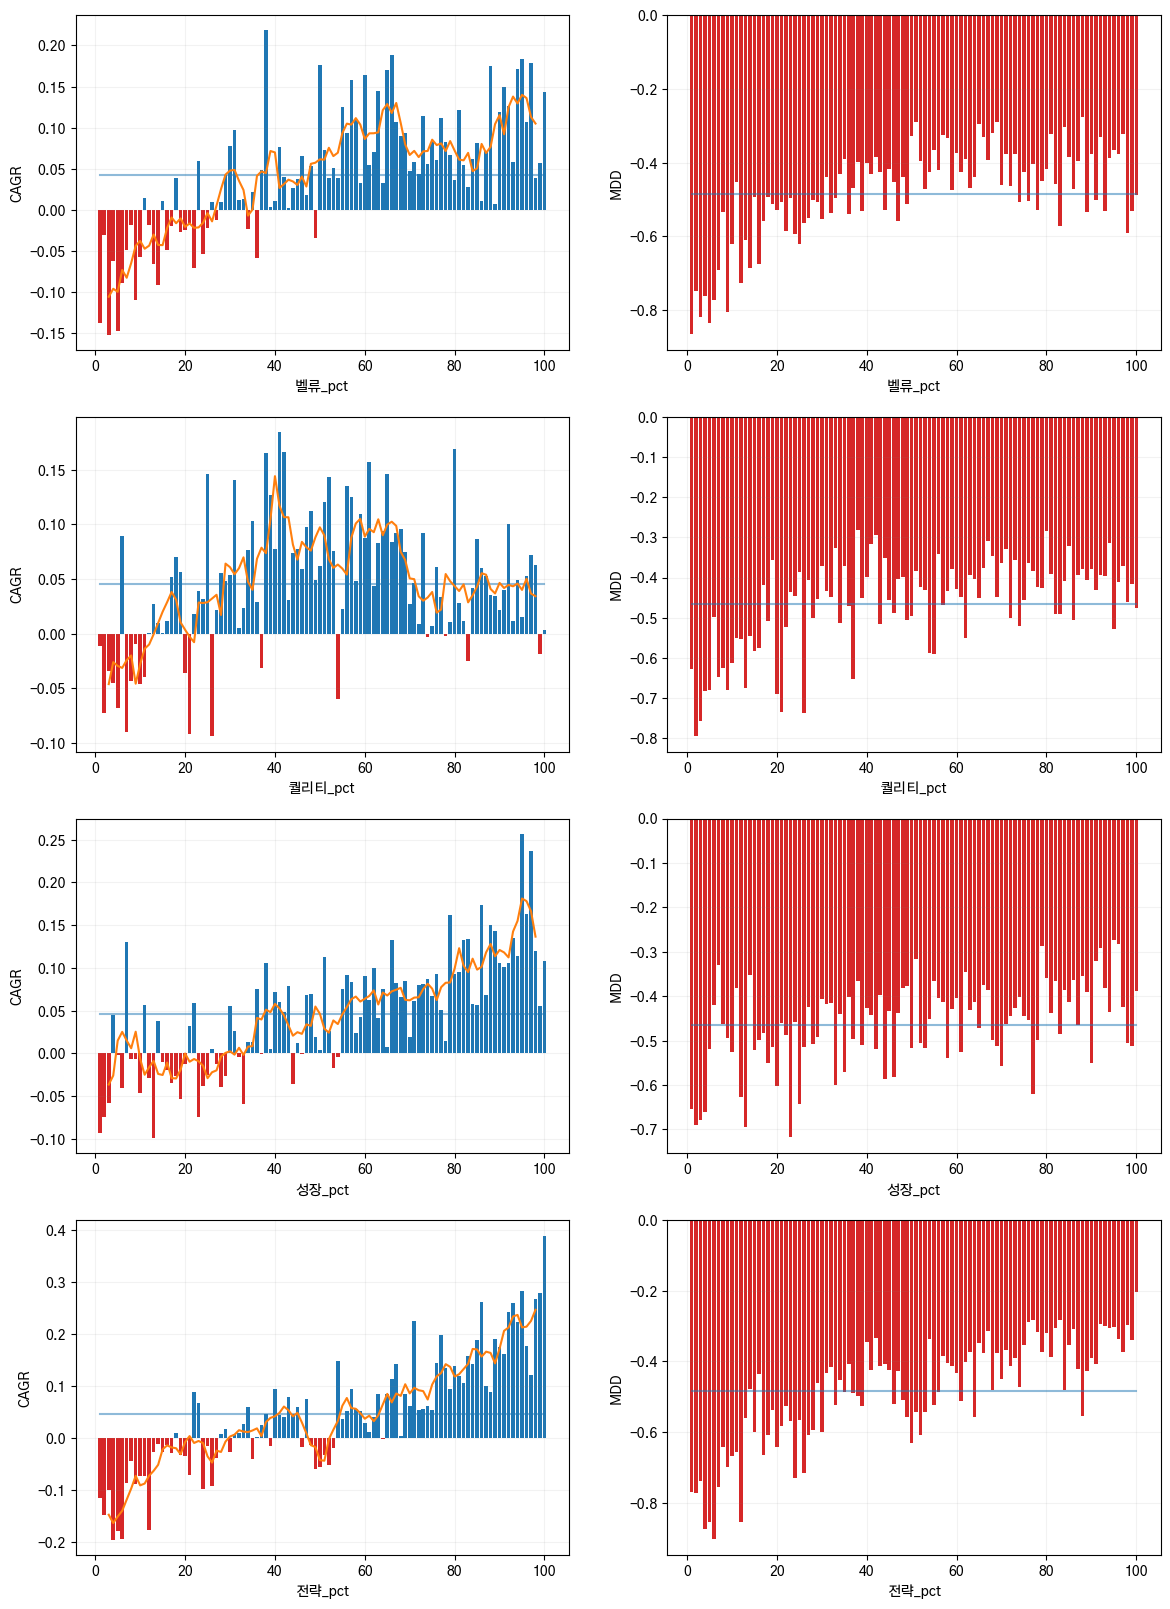

In [174]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary

In [175]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

port_size = 30
port = result2.groupby(_key).apply(lambda x: x.sort_values("전략", ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].dropna().index], revisions["전략 누적수익률"].dropna().tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)

result3 = port[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "val_last",
    "P_pct", "성장_pct", "벨류_pct", "퀄리티_pct", f"{factor}_pct"
]]
result3.to_csv(".analysis/port.csv")
result3

전략
        CAGR                                         MDD      Mean
전략  0.358010   (-0.2447863867902219, (2018-05, 2018-10))  0.028634
BM  0.028985  (-0.39749020543683156, (2018-05, 2020-03))  0.004278


code     종목명       수익률         매수일         매도일  \
매수년월    매도년월                                                               
2014-04 2014-05 682     024940    PN풍년  0.103774  2014-04-30  2014-05-30   
                835     035460   기산텔레콤 -0.010638  2014-04-30  2014-05-30   
                1015    007370    진양제약 -0.038835  2014-04-30  2014-05-30   
                744     051630    진양화학  0.218310  2014-04-30  2014-05-30   
                214     071280  로체시스템즈 -0.207506  2014-04-30  2014-05-30   
...                        ...     ...       ...         ...         ...   
2023-09 2023-10 199272  025880   케이씨피드 -0.023211  2023-09-27  2023-10-31   
                200076  142210   유니트론텍 -0.158576  2023-09-27  2023-10-31   
                199130  123040  엠에스오토텍 -0.019157  2023-09-27  2023-10-31   
                199450  252500   세화피앤씨  0.024000  2023-09-27  2023-10-31   
                200391  010240      흥국 -0.053055  2023-09-27  2023-10-31   

                           매수가     매도가     val_last  P_pct  성장_pct  벨류_pct  \
매수년월    매도년월                                                                 
2014-04 2014-05 682     2120.0  2340.0  125729995.0    3.0    93.0    92.0   
                835     2350.0  2325.0  675374365.0    9.0    89.0    83.0   
                1015    4120.0  3960.0  241180105.0   18.0    96.0    84.0   
                744     2840.0  3460.0  109249025.0    9.0    93.0    59.0   
                214     4530.0  3590.0  458169145.0   11.0    93.0    79.0   
...                        ...     ...          ...    ...     ...     ...   
2023-09 2023-10 199272  2585.0  2525.0  126594005.0    6.0    92.0    74.0   
                200076  4635.0  3900.0  513519030.0   27.0    85.0    76.0   
                199130  5220.0  5120.0  731664470.0   61.0    96.0    95.0   
                199450  1000.0  1024.0  142770028.0    6.0    94.0    68.0   
                200391  6220.0  5890.0  137257640.0   21.0    94.0    68.0   

                        퀄리티_pct  전략_pct  
매수년월    매도년월                             
2014-04 2014-05 682        55.0   100.0  
                835        73.0   100.0  
                1015       74.0   100.0  
                744        87.0   100.0  
                214        68.0   100.0  
...                         ...     ...  
2023-09 2023-10 199272     67.0    99.0  
                200076     93.0    99.0  
                199130     96.0    99.0  
                199450     69.0    99.0  
                200391     83.0    99.0  

[3420 rows x 13 columns]

In [176]:
revisions.to_csv(".analysis/revisions.csv")
revisions

,,BM 수익률,전략 수익률,성능,BM 누적수익률,전략 누적수익률,BM DD,전략 DD
매수년월,매도년월,,,,,,,
2014-04,2014-05,-0.010339,0.013614,0.023953,0.989661,1.013614,0.000000,0.000000
2014-05,2014-06,-0.013571,0.023809,0.037380,0.976230,1.037747,-0.013571,0.000000
2014-06,2014-07,0.014194,0.065641,0.051448,0.990087,1.105866,0.000000,0.000000
2014-07,2014-08,0.039853,0.050119,0.010266,1.029545,1.161291,0.000000,0.000000
2014-08,2014-09,0.005352,0.054619,0.049267,1.035055,1.224719,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-05,2023-06,0.006412,0.056625,0.050213,1.563446,20.436324,-0.241160,0.000000
2023-06,2023-07,-0.029541,-0.048103,-0.018562,1.517259,19.453268,-0.263577,-0.048103
2023-07,2023-08,0.016191,0.013521,-0.002670,1.541825,19.716293,-0.251654,-0.035233


total            114.000000
out-perform       91.000000
under-perform     23.000000
승률                 0.798246
누적 성능             13.499116
dtype: float64

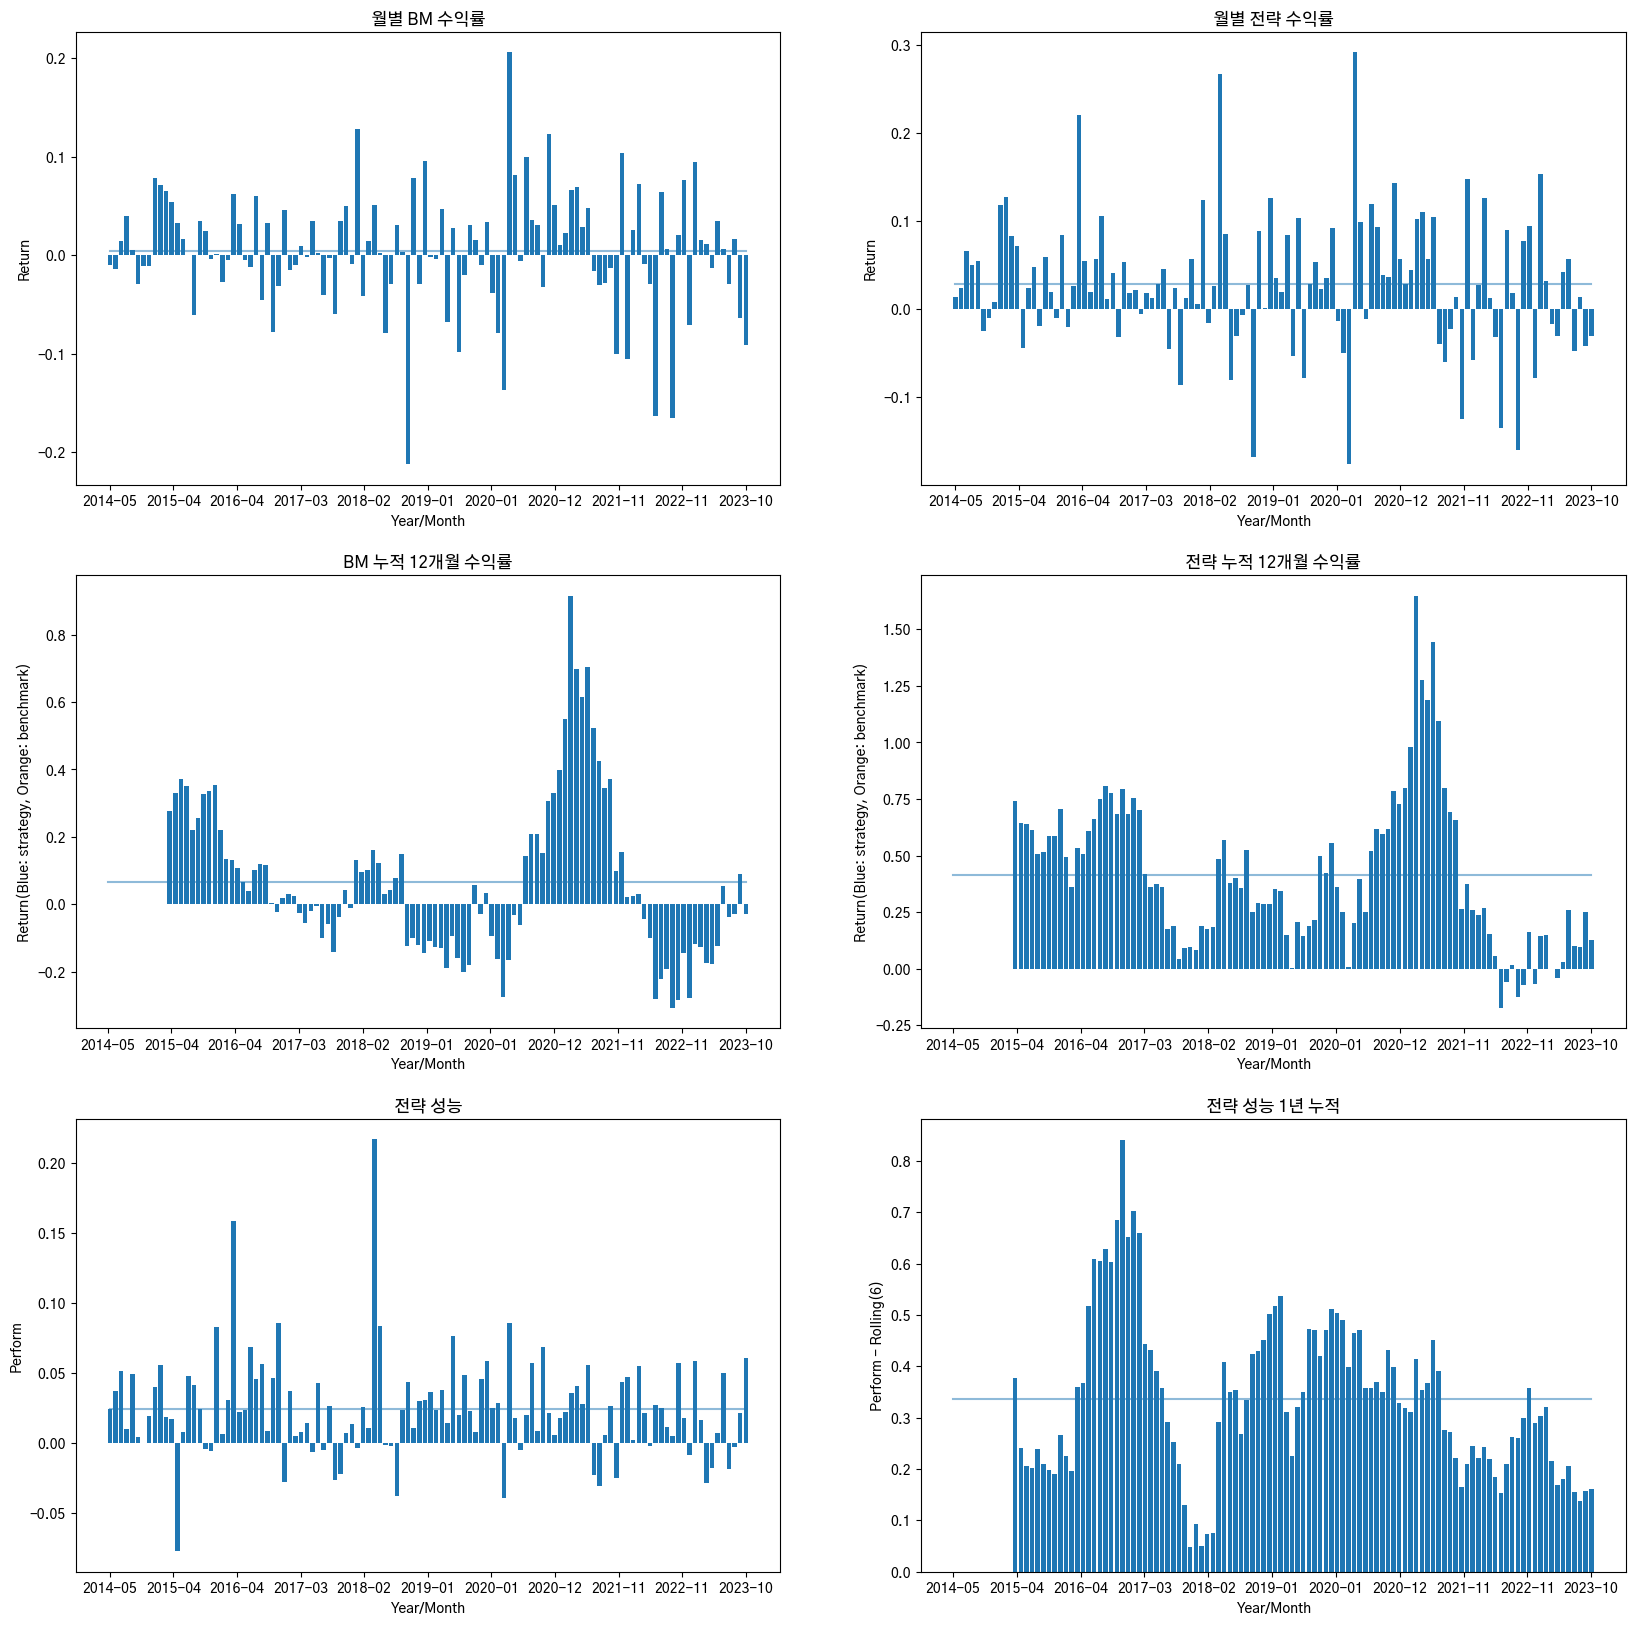

In [177]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0).sum(),
    "under-perform": (revisions["성능"] < 0).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

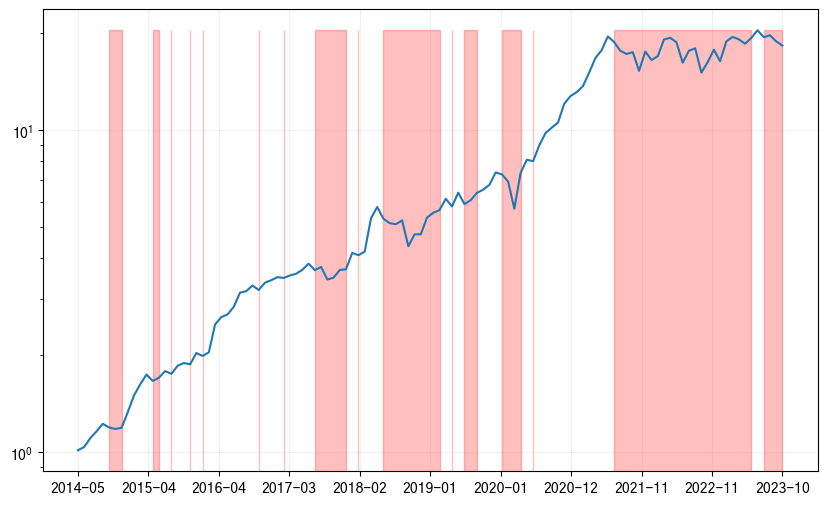

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
x_values = months
y_values = revisions["전략 누적수익률"]
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)
plt.fill_between(
    x_values, y_values.max(),
    where=(revisions["전략 DD"] < 0),
    color="red", alpha=0.25
)